In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

nx_t = '/kaggle/input/mvi-dataset/netflix_titles.csv'
imdb_m = '/kaggle/input/mvi-dataset/IMDb_movies.csv'
imdb_r = '/kaggle/input/mvi-dataset/IMDb_ratings.csv'

# netflix data frame
nx_df = pd.read_csv(nx_t)

# imdb movies datat frame
imdb_m_df = pd.read_csv(imdb_m)

# imdb ratings data frame
imdb_r_df = pd.read_csv(imdb_r)

# print(nx_df.head(), imdb_m_df.head(), imdb_r_df.head())





/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
# MISSING DATA HANDLING
#------------------

# Perform left join => [nx_df OUTER LEFT JOIN imdb_m_df]
nx_df = nx_df.merge(imdb_m_df, on='title', how='left', suffixes=('', '_y'))

# Drop any duplicate from the join
nx_df = nx_df.drop_duplicates(subset='show_id').reset_index(drop=True)

# Find any NaN cell from nx_df and replace it with the respective imdb_m_df value
nx_df['director'][nx_df['director'].isnull()] = nx_df['director_y']
nx_df['cast'][nx_df['cast'].isnull()] = nx_df['actors']
nx_df['country'][nx_df['country'].isnull()] = nx_df['country_y']

# Form the appropriate column list to drop from nx_df
imdb_cols = imdb_m_df.columns.to_list()
[imdb_cols.remove(c) for c in ['title', 'country', 'director', 'duration', 'description']]
[imdb_cols.append(c) for c in ['country_y', 'director_y', 'duration_y', 'description_y']]

# Remove any unecessairy column 
nx_df.drop(columns=imdb_cols, inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == "":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [3]:
nx_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5607 non-null   object
 4   cast          7106 non-null   object
 5   country       7307 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


# DATA VISUALIZATION

Country with the most content is United States, having produced 3297 movies and tv shows.


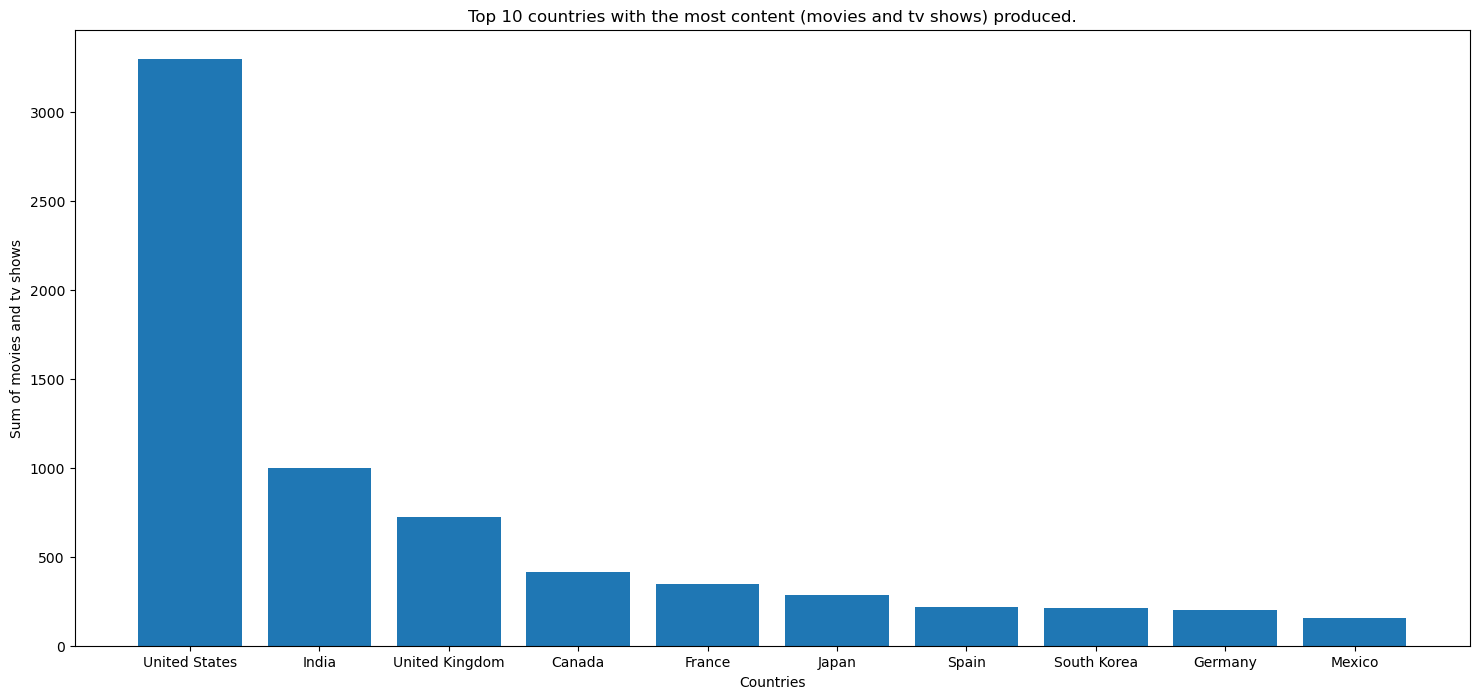

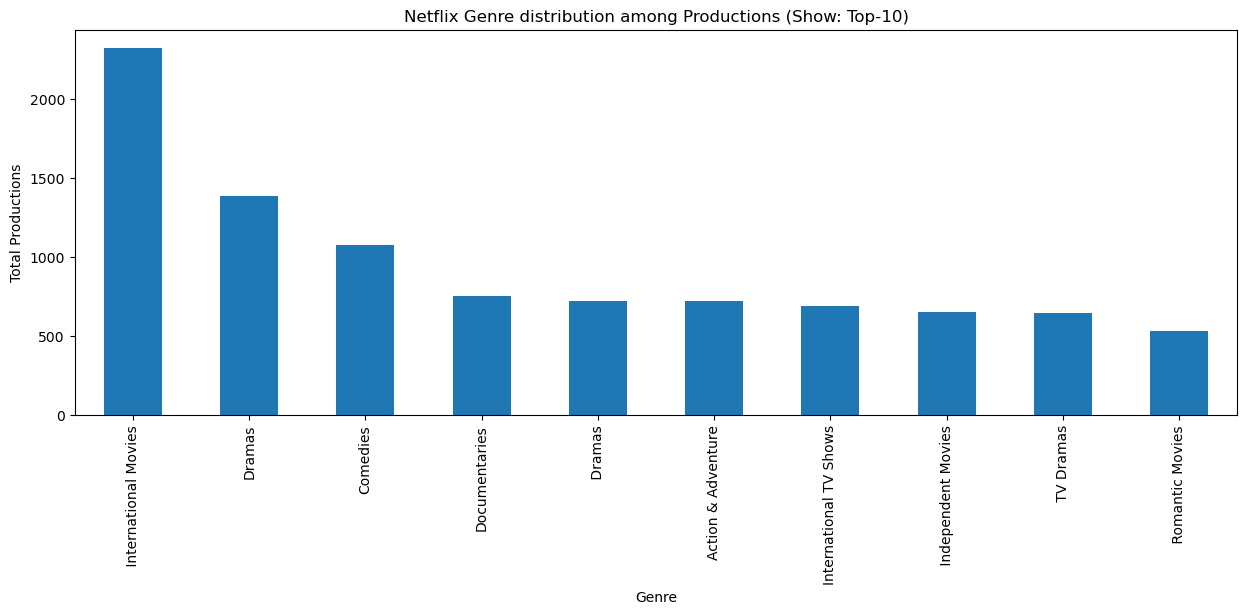

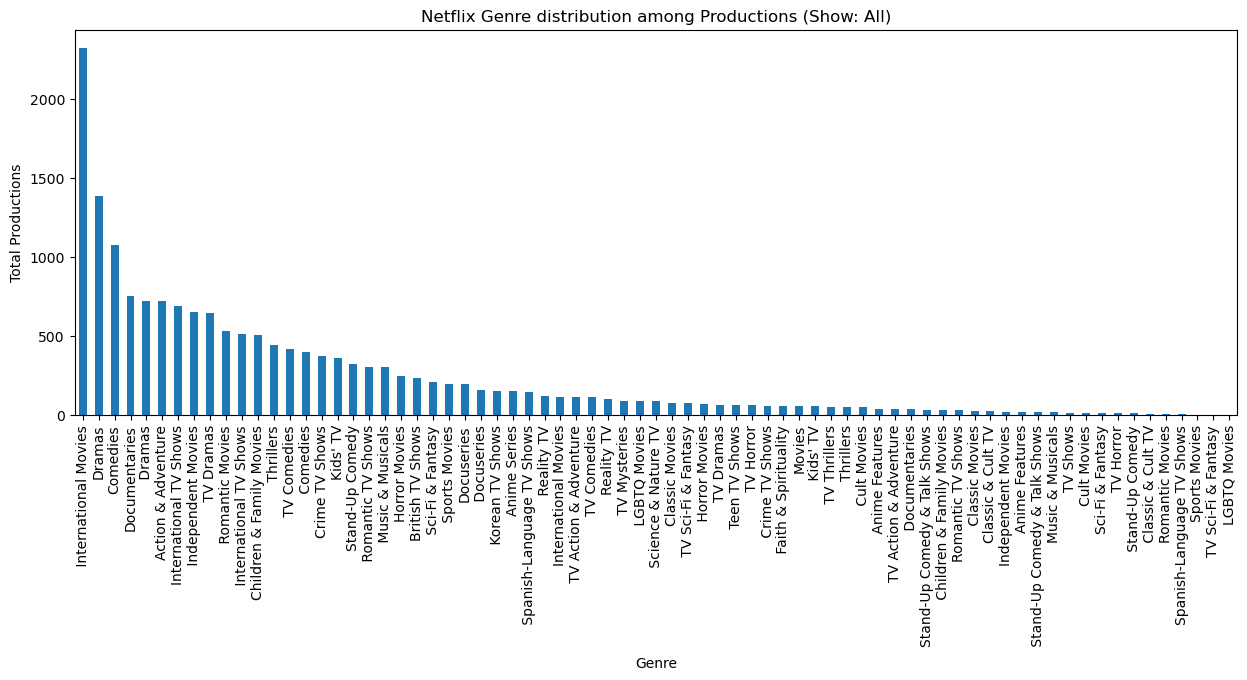

In [4]:
# RUNNING AQUERY TO SEE WHICH COUNTRY HAS MOST CONTENT

def countries_content(df, countries={}):
    # For each row
    for producers in df['country'].dropna():
        # Split the row into multiple countries (if necessary)
        for country in str(producers).strip().split(','):
            c = country.strip()
            # Store each country in the dictionary
            countries[c] = 1 if c not in countries else countries[c] + 1
    return countries

countries = countries_content(nx_df)
# # The country with the most content is simply the max of the countries' dictionary
win_countr = max(countries, key=countries.get)

print(f'Country with the most content is {win_countr}, having produced {countries[win_countr]} movies and tv shows.')

# Sort the countries and draw a bar plot for demonstration purposes
countries = dict(sorted(countries.items(), key=lambda item: item[1], reverse=True))

topn = 10
fig, ax = plt.subplots(1, 1, figsize=[18, 8])
plt.bar(x=[i for j,i in enumerate(countries) if j < topn], height=[countries[i] for j,i in enumerate(countries) if j < topn])
ax.set_title(f'Top {topn} countries with the most content (movies and tv shows) produced.')
ax.set_xlabel('Countries')
ax.set_ylabel('Sum of movies and tv shows')
plt.show()


# SUMMARIZING THE TYPE OF CONTENT
def get_genre_stats(topk = 8):
  genre_info = nx_df[['listed_in']].dropna().rename({'listed_in' : 'Genre'}, axis=1)
  # Create new rows, each having exactly 1 genre (by splitting multi-genre productions)
  genre_info['Genre'] = genre_info['Genre'].str.strip().str.split(',')
  genre_info = genre_info.explode('Genre')
  genre_info = genre_info.explode('Genre').reset_index()
  genre_info = genre_info.groupby(by=['Genre']).count()
  genre_info.rename({'index' : 'Count'}, axis=1, inplace=True)
  genre_info = genre_info.sort_values(by=['Count'], ascending=False)

  def plot_topk_genre(info, topk):
    desc = f'(Show: Top-{topk})'
    if topk == len(genre_info.index):
      desc = '(Show: All)'
    genre_info.head(topk).plot(kind='bar', width=0.5, xlabel='Genre', legend=False, figsize = (15,5),
                          ylabel='Total Productions', title=f'Netflix Genre distribution among Productions {desc}')
    plt.show()
    print()

  plot_topk_genre(genre_info, topk)
  plot_topk_genre(genre_info, genre_info.size)

get_genre_stats(topk = 10)

> # Recommendation System

In [5]:
import pandas as pd
import time
# Import vectorizers (CountVect., and TF-IDF Vect.)
from sklearn.feature_extraction.text import CountVectorizer as cvect
from sklearn.feature_extraction.text import TfidfVectorizer as tfvect
from scipy.spatial.distance import cdist

# Stopword container via NLTK
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Spacy for the lemmatization process
import spacy

nlp = spacy.load('en_core_web_sm')

# Function to return a list of lemmas (without punctuation and pronouns)
lemmatok = lambda doc: [token.lemma_ for token in nlp(doc) if token.lemma_ != '-PRON-' and not token.is_punct]
####### END - 1

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Lemmatising all of the titles and descriptions
print("start lemmatize")
start = time.time()
nx_df_lem = nx_df.copy()
nx_df_lem['description'] = nx_df_lem['description'].apply(lambda x: " ".join(lemmatok(x)))
nx_df_lem['title'] = nx_df_lem['title'].apply(lambda x: " ".join(lemmatok(x)))

# Extracting descriptions and titles and merging them into individual strings
desc_l = nx_df_lem['description'].to_list()
title_l = nx_df_lem['title'].to_list()
desc_titles = [( desc_l[i] + ' ' + title_l[i] ) for i in range(len(desc_l))]
print(f"finish lemmatize in {time.time() - start}")
####### END - 2

start lemmatize
finish lemmatize in 116.38147115707397


In [7]:
# BoW - BOOLEAN BAG OF WORDS
# Declaring vectorizers (unigram, bigram)
print("start BoW")
start = time.time()
cv_uni = cvect(ngram_range=(1, 1), stop_words=stopwords.words(), min_df=5, max_df=0.96, max_features=3000, binary=True)
cv_bi = cvect(ngram_range=(2, 2), stop_words=stopwords.words(), min_df=2, binary=True)
cv_unibi = cvect(ngram_range=(1, 2), stop_words=stopwords.words(), min_df=2, max_features=4000, binary=True)

# Transforming
cv_tr_u = cv_uni.fit_transform(desc_titles)
cv_tr_b = cv_bi.fit_transform(desc_titles)
cv_tr_ub = cv_unibi.fit_transform(desc_titles)

# Creating the respective dataframes

# DataFrame consisting of unigrams
cv_u_df = pd.DataFrame(cv_tr_u.toarray(), columns = cv_uni.get_feature_names_out(), index= nx_df_lem['show_id'])
# DataFrame consisting of bigrams
cv_b_df = pd.DataFrame(cv_tr_b.toarray(), columns = cv_bi.get_feature_names_out(), index= nx_df_lem['show_id'])
# DataFrame consisting of both unigrams and bigrams
cv_df = pd.DataFrame(cv_tr_ub.toarray(), columns = cv_unibi.get_feature_names_out(), index= nx_df_lem['show_id'])
print(f"finished BoW in {time.time() - start}")
####### END - 3

start BoW


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aldiz', 'baiknya', 'baizik', 'berkali', 'bukatzeko', 'edota', 'eze', 'ezpabere', 'ezpada', 'ezperen', 'gainera', 'gainerontzean', 'guztiz', 'hainbestez', 'horra', 'kali', 'kurangnya', 'mata', 'olah', 'onların', 'ordea', 'osterantzean', 'printr', 'sekurang', 'setidak', 'tama', 'tidaknya', 'δι', 'арбаң', 'арсалаң', 'афташ', 'бай', 'бале', 'баски', 'батыр', 'баҳри', 'болои', 'бүгжең', 'бұтыр', 'валекин', 'вақте', 'вой', 'вуҷуди', 'гар', 'гарчанде', 'далаң', 'даме', 'ербелең', 'жалт', 'жұлт', 'карда', 'кошки', 'куя', 'күңгір', 'кӣ', 'магар', 'майлаш', 'митың', 'модоме', 'нияти', 'онан', 'оре', 'паһ', 'рӯи', 'салаң', 'сар', 'сұлаң', 'сұрт', 'тарбаң', 'тразе', 'ту', 'тыржың', 'тұрс', 'хом', 'хуб', 'чаро', 'чи', 'чун', 'чунон', 'шарте', 'шұңқ', 'ыржың', 'қадар', 'қайқаң', 'қалт', 'қаңғыр', 'қаңқ', 

finished BoW in 1.4436402320861816


In [8]:
# TF-IDF
# Vectorizers (unigram, bigram)
print("start TF-IDF")
start = time.time()
tf_uni = tfvect(ngram_range=(1, 1), stop_words=stopwords.words(), min_df=2, max_df=0.96, max_features=3000)
tf_bi = tfvect(ngram_range=(2, 2), stop_words=stopwords.words(), min_df=2)
tf_unibi = tfvect(ngram_range=(1, 2), stop_words=stopwords.words(), min_df=2, max_features=4000)

# Transform 
tf_tr_u = tf_uni.fit_transform(desc_titles)
tf_tr_b = tf_bi.fit_transform(desc_titles)
tf_tr_ub = tf_unibi.fit_transform(desc_titles)

# Creating the respective dataframes

# DataFrame consisting of unigrams
tf_u_df = pd.DataFrame(tf_tr_u.toarray(), columns = tf_uni.get_feature_names_out(), index= nx_df_lem['show_id'])
# DataFrame consisting of bigrams
tf_b_df = pd.DataFrame(tf_tr_b.toarray(), columns = tf_bi.get_feature_names_out(), index= nx_df_lem['show_id'])
# DataFrame consisting of both unigrams and bigrams
tf_df = pd.DataFrame(tf_tr_ub.toarray(), columns = tf_unibi.get_feature_names_out(), index= nx_df_lem['show_id'])
print(f"end TF-IDF {time.time() - start}")
####### END - 4

start TF-IDF
end TF-IDF 1.6900548934936523


In [9]:
# SIMILARITY CALCULATION FUNCTION
print("start calculations...")
start = time.time()
'''
Receives two dataframes, df1, df2 and a metric

Computes the distance between each pair of the two collections of inputs.

Returns a 2D list
'''
def similar(df1, df2, metric):
    return 1-cdist(df1, df2, metric)

# BoW - unigram
print("start BoW similiar - unigram")
start = time.time()
cv_uni_sim = similar(cv_u_df, cv_u_df, 'jaccard')
# BoW - bigram 
cv_bi_sim = similar(cv_b_df, cv_b_df, 'jaccard')
# BoW unigram & bigram
cv_sim = similar(cv_df, cv_df, 'jaccard')
print(f"finish BoW - unigram {time.time() - start}")

print("start TF-IDF - unigram")
# TF-IDF - unigram
tf_uni_sim = similar(tf_u_df, tf_u_df, 'cosine')
# TF-IDF - bigram
tf_bi_sim = similar(tf_b_df, tf_b_df, 'cosine')
# TF-IDF unigram & bigram
tf_sim = similar(tf_df, tf_df, 'cosine')

def dict_prep(l):
    d = {}
    # Form the keys
    for i in range(len(l)):
        idx = 's' + str(i+1) 
        d[idx] = l[i]

    # Forming the respective tuples, sort them and keep top 100
    for j, key in enumerate(d):
        l = list(d[key])
        d[key] = [(l[i], 's' + str(i+1)) for i in range(len(l))]
        d[key] = [k for k in d[key] if k[1] != key]
        d[key].sort(reverse=True)
        d[key] = d[key][:100]

    return d
     
# Forming all the necessary dictionaries
print("forming dicts")
cv_uni_sim = dict_prep(cv_uni_sim) 
cv_bi_sim = dict_prep(cv_bi_sim) 
cv_sim = dict_prep(cv_sim) 

tf_uni_sim = dict_prep(tf_uni_sim) 
tf_bi_sim = dict_prep(tf_bi_sim) 
tf_sim = dict_prep(tf_sim) 

# Function for stats printing
def pretty_print(l, title, N):
    print(f'Top {N} recommended productions for "{title}":')
    print('-----------------------------------------------')
    print('INDEX -- TITLE -- SIMILARITY')
    for i, (est, t) in enumerate(l):
        print(f'{i+1}. -- {t} -- {str(est)[:4]}')

'''
Receives a movie title, a number, a method and a ngram tuple
Returns the top "N" most similar movies to the given movie title

If "method" is "boolean", the information is being extracted from the BoW method's trained dataset
If "method" is "tf-idf", the information is being extracted from the TF-IDF method's trained dataset

If "ngram" is (1, 1), the information is only being extracted from the set trained on unigrams
If "ngram" is (1, 2), the information is being extracted from the set trained on unigrams and bigrams
If "ngram" is (2, 2), the information is only being extracted from the set trained on bigrams
'''
def get_similar_movies1(movie_title, N=10, method='boolean', ngram=(1, 2)):
    # Try and fetch the given title's show id
    try:
        id = nx_df[nx_df['title'] == movie_title]['show_id'].values[0]
    except:
        print(f'Error, "{movie_title}" does not exist in the database.')
        return None

    sims = None
    # Boolean method
    if method == 'boolean':
        # Extract the appropriate list of similar movie ids from a trained set
        sdata = cv_uni_sim[id] if ngram==(1, 1) else cv_sim[id] if ngram==(1, 2)  \
                else cv_bi_sim[id] if ngram==(2, 2) else None

        if sdata == None:
            print('Error, ngram parameter has to be either (1, 1), (1, 2) or (2, 2).')
            return sdata
        # Keep only the top "N" movies
        sims = sdata[:N]

    # TF-IDF method
    elif method == 'tf-idf':
        # Extract the appropriate list of similar movie ids from a trained set
        sdata = tf_uni_sim[id] if ngram==(1, 1) else tf_sim[id] if ngram==(1, 2)  \
                else tf_bi_sim[id] if ngram==(2, 2) else None
        
        if sdata == None:
            print('Error, ngram parameter has to be either (1, 1), (1, 2) or (2, 2).')
            return sdata
        sims = sdata[:N]
        
    else:
        print('Error, method parameter has to be either "boolean" or "tf-idf".')
        return None
    # Return the resulting movie titles and similarity rates instead of movie ids
    return [(val, nx_df[nx_df['show_id'] == id2]['title'].values[0]) for (val, id2) in sims]

print(f"finished calculation {time.time() - start}")

start calculations...
start BoW similiar - unigram
finish BoW - unigram 1946.5215077400208
start TF-IDF - unigram
forming dicts
finished calculation 2913.755468606949


In [3]:

N = 10
mtitle = 'Gypsy'

print(f'\n\n[Boolean - Unigrams]> Top {N} Recommended productions for "{mtitle}" : \n')
pretty_print(get_similar_movies1(mtitle, method='boolean', ngram=(1, 1)), mtitle, N)

print(f'\n\n[Boolean - Unigrams & Bigrams]> Top {N} Recommended productions for "{mtitle}" : \n')
pretty_print(get_similar_movies1(mtitle, method='boolean', ngram=(1, 2)), mtitle, N)

print(f'\n\n[Boolean - Bigrams]> Top {N} Recommended productions for "{mtitle}" : \n')
pretty_print(get_similar_movies1(mtitle, method='boolean', ngram=(2, 2)), mtitle, N)

print(f'\n\n[TF-IDF - Unigrams]> Top {N} Recommended productions for "{mtitle}" : \n')
pretty_print(get_similar_movies1(mtitle, method='tf-idf', ngram=(1, 1)), mtitle, N)

print(f'\n\n[TF-IDF - Unigrams & Bigrams]> Top {N} Recommended productions for "{mtitle}" : \n')
pretty_print(get_similar_movies1(mtitle, method='tf-idf', ngram=(1, 2)), mtitle, N)

print(f'\n\n[TF-IDF - Bigrams]> Top {N} Recommended productions for "{mtitle}" : \n')
pretty_print(get_similar_movies1(mtitle, method='tf-idf', ngram=(2, 2)), mtitle, N)

mtitle = 'Last Breath'

print(f'\n\n[Boolean - Unigrams]> Top {N} Recommended productions for "{mtitle}" : \n')
pretty_print(get_similar_movies1(mtitle, method='boolean', ngram=(1, 1)), mtitle, N)

print(f'\n\n[Boolean - Unigrams & Bigrams]> Top {N} Recommended productions for "{mtitle}" : \n')
pretty_print(get_similar_movies1(mtitle, method='boolean', ngram=(1, 2)), mtitle, N)

print(f'\n\n[Boolean - Bigrams]> Top {N} Recommended productions for "{mtitle}" : \n')
pretty_print(get_similar_movies1(mtitle, method='boolean', ngram=(2, 2)), mtitle, N)

print(f'\n\n[TF-IDF - Unigrams]> Top {N} Recommended productions for "{mtitle}" : \n')
pretty_print(get_similar_movies1(mtitle, method='tf-idf', ngram=(1, 1)), mtitle, N)

print(f'\n\n[TF-IDF - Unigrams & Bigrams]> Top {N} Recommended productions for "{mtitle}" : \n')
pretty_print(get_similar_movies1(mtitle, method='tf-idf', ngram=(1, 2)), mtitle, N)

print(f'\n\n[TF-IDF - Bigrams]> Top {N} Recommended productions for "{mtitle}" : \n')
pretty_print(get_similar_movies1(mtitle, method='tf-idf', ngram=(2, 2)), mtitle, N)



[Boolean - Unigrams]> Top 10 Recommended productions for "Lucy" : 

Error, "Lucy" does not exist in the database.
Top 10 recommended productions for "Lucy":
-----------------------------------------------
INDEX -- TITLE -- SIMILARITY


TypeError: 'NoneType' object is not iterable

In [11]:
'''
Receives a description, a number, a method and a ngram tuple
Returns the top "N" most similar movies to the given keywords/description

If "method" is "boolean", the information is being trained with BoW method
If "method" is "tf-idf", the information is being trained with TF-IDF method

If "ngram" is (1, 1), the information is only being extracted from the set trained on unigrams
If "ngram" is (1, 2), the information is being extracted from the set trained on unigrams and bigrams
If "ngram" is (2, 2), the information is only being extracted from the set trained on bigrams
'''
def get_similar_movies2(descr, N=10, method='tf-idf', ngram=(1, 2)):
    
    dsc = descr
    # Lemmatise the given description
    descr = " ".join(lemmatok(descr))
    # Add the given description to the dataset
    descriptions = nx_df_lem['description'].to_list() + [descr]
    # Add an index for the user's input description
    new_indices = nx_df_lem['show_id'].append(pd.Series(['User arg']))

    # Transform all the existing descriptions along with the user's input and create 
    # the appropriate DataFrames (based on the provided method & ngram)
    sims = None
    # Boolean method
    if method == 'boolean':
        df = None
        if ngram==(1, 2):
            tr_ub = cv_unibi.fit_transform(descriptions)
            df = pd.DataFrame(tr_ub.toarray(), columns = cv_unibi.get_feature_names(), index=new_indices)
        
        elif ngram==(1, 1):
            tr_u = cv_uni.fit_transform(descriptions)
            df = pd.DataFrame(tr_u.toarray(), columns = cv_uni.get_feature_names(), index=new_indices)

        elif ngram==(2, 2):
            tr_b = cv_bi.fit_transform(descriptions)
            df = pd.DataFrame(tr_b.toarray(), columns = cv_bi.get_feature_names(), index=new_indices)
        
        else:
            print('Error, ngram parameter has to be either (1, 1), (1, 2) or (2, 2).')
            return None

        # Keep a dataframe consisting only of the user's input feature vector 
        df1 = df.tail(1)
        df.drop(df.tail(1).index, inplace=True)
        # Compute and keep only the top "N" most similar movies to the user's description via similar()
        sdata = dict_prep(similar(df1, df, 'jaccard'))
        sims = list(sdata.values())[0][:N]

    elif method == 'tf-idf':
        df = None
        if ngram==(1, 2):
            tr_ub = tf_unibi.fit_transform(descriptions)
            df = pd.DataFrame(tr_ub.toarray(), columns = tf_unibi.get_feature_names(), index=new_indices)

        elif ngram==(1, 1):
            tr_u = tf_uni.fit_transform(descriptions)
            df = pd.DataFrame(tr_u.toarray(), columns = tf_uni.get_feature_names(), index=new_indices)

        elif ngram==(2, 2):
            tr_b = tf_bi.fit_transform(descriptions)    
            df = pd.DataFrame(tr_b.toarray(), columns = tf_bi.get_feature_names(), index=new_indices)

        else:
            print('Error, ngram parameter has to be either (1, 1), (1, 2) or (2, 2).')
            return None
        
        df1 = df.tail(1)
        df.drop(df.tail(1).index, inplace=True)
        # Compute and keep only the top "N" most similar movies to the user's description via similar()
        sdata = dict_prep(similar(df1, df, 'cosine'))
        sims = list(sdata.values())[0][:N]
        
    else:
        print('Error, method parameter has to be either "boolean" or "tf-idf".')
        return None

    # Return the resulting movie titles and similarity rates instead of movie ids
    return [(val, nx_df[nx_df['show_id'] == id2]['title'].values[0]) for (val, id2) in sims]
     

In [2]:
N = 10
dsc = 'action drama romance'

print(f'\n\n[Boolean - Unigrams]> Top {N} Recommended productions based on the description "{dsc}" : \n')
pretty_print(get_similar_movies2(dsc, method='boolean', ngram=(1, 1)), dsc, N)

print(f'\n\n[Boolean - Unigrams & Bigrams]> Top {N} Recommended productions based on the description "{dsc}" : \n')
pretty_print(get_similar_movies2(dsc, method='boolean', ngram=(1, 2)), dsc, N)

print(f'\n\n[Boolean - Bigrams]> Top {N} Recommended productions based on the description "{dsc}" : \n')
pretty_print(get_similar_movies2(dsc, method='boolean', ngram=(2, 2)), dsc, N)

print(f'\n\n[TF-IDF - Unigrams]> Top {N} Recommended productions based on the description "{dsc}" : \n')
pretty_print(get_similar_movies2(dsc, method='tf-idf', ngram=(1, 1)), dsc, N)

print(f'\n\n[TF-IDF - Unigrams & Bigrams]> Top {N} Recommended productions based on the description "{dsc}" : \n')
pretty_print(get_similar_movies2(dsc, method='tf-idf', ngram=(1, 2)), dsc, N)

print(f'\n\n[TF-IDF - Bigrams]> Top {N} Recommended productions based on the description "{dsc}" : \n')
pretty_print(get_similar_movies2(dsc, method='tf-idf', ngram=(2, 2)), dsc, N)


dsc = 'Psycological thriller with psychic patients'
print(f'\n\n[Boolean - Unigrams]> Top {N} Recommended productions based on the description "{dsc}" : \n')
pretty_print(get_similar_movies2(dsc, method='boolean', ngram=(1, 1)), dsc, N)

print(f'\n\n[Boolean - Unigrams & Bigrams]> Top {N} Recommended productions based on the description "{dsc}" : \n')
pretty_print(get_similar_movies2(dsc, method='boolean', ngram=(1, 2)), dsc, N)

print(f'\n\n[Boolean - Bigrams]> Top {N} Recommended productions based on the description "{dsc}" : \n')
pretty_print(get_similar_movies2(dsc, method='boolean', ngram=(2, 2)), dsc, N)

print(f'\n\n[TF-IDF - Unigrams]> Top {N} Recommended productions based on the description "{dsc}" : \n')
pretty_print(get_similar_movies2(dsc, method='tf-idf', ngram=(1, 1)), dsc, N)

print(f'\n\n[TF-IDF - Unigrams & Bigrams]> Top {N} Recommended productions based on the description "{dsc}" : \n')
pretty_print(get_similar_movies2(dsc, method='tf-idf', ngram=(1, 2)), dsc, N)

print(f'\n\n[TF-IDF - Bigrams]> Top {N} Recommended productions based on the description "{dsc}" : \n')
pretty_print(get_similar_movies2(dsc, method='tf-idf', ngram=(2, 2)), dsc, N)
     



[Boolean - Unigrams]> Top 10 Recommended productions based on the description "kids rock-band musical drama" : 

Top 10 recommended productions for "kids rock-band musical drama":
-----------------------------------------------
INDEX -- TITLE -- SIMILARITY
1. -- Ratones Paranoicos: The Band that Rocked Argentina -- 0.18
2. -- Paradox -- 0.18
3. -- My Little Pony Equestria Girls: Rainbow Rocks -- 0.18
4. -- Rock On!! -- 0.16
5. -- Our Shining Days -- 0.16
6. -- Long Time Running -- 0.16
7. -- ZZ TOP: THAT LITTLE OL' BAND FROM TEXAS -- 0.15
8. -- The Show Must Go On: The Queen + Adam Lambert Story -- 0.15
9. -- Once in a Lifetime Sessions with Snow Patrol -- 0.15
10. -- I Am Me! -- 0.15


[Boolean - Unigrams & Bigrams]> Top 10 Recommended productions based on the description "kids rock-band musical drama" : 

Top 10 recommended productions for "kids rock-band musical drama":
-----------------------------------------------
INDEX -- TITLE -- SIMILARITY
1. -- Ratones Paranoicos: The Band 